In [1]:
# Install required packages for NER implementation
# !pip install transformers torch scikit-learn seqeval pandas numpy matplotlib seaborn tqdm
# !pip install datasets accelerate

---


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from sklearn.metrics import classification_report, confusion_matrix
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
CONFIG = {
    'model_name': 'bert-base-multilingual-cased',  # Multilingual BERT
    'max_length': 512,
    'batch_size': 8,
    'learning_rate': 2e-5,
    'epochs': 3,
    'weight_decay': 0.01,
    'warmup_steps': 500,
    'gradient_accumulation_steps': 2,
    'fp16': True if torch.cuda.is_available() else False,
    'dataset_path': r'e:\SEMESTER 6\TEXT MINING\Uas\Datasets\ANOTASI\DATASET_BERT_SENTENCE.csv'
}


Using device: cuda
Using device: cuda


In [3]:
# Load and analyze the dataset
print("Loading dataset...")
df = pd.read_csv(CONFIG['dataset_path'])
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Analyze label distribution
all_labels = []
for labels in df['labels']:
    if pd.notna(labels):
        all_labels.extend(labels.split())

label_counts = pd.Series(all_labels).value_counts()
print("\nLabel distribution:")
print(label_counts)

# Create label mapping with focus on B and I labels
unique_labels = sorted(list(set(all_labels)))
print(f"\nUnique labels ({len(unique_labels)}): {unique_labels}")

# Create label to ID mapping
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"\nLabel to ID mapping:")
for label, id_ in label2id.items():
    print(f"{label}: {id_}")

# Count B and I vs O labels
b_i_labels = [label for label in unique_labels if label.startswith('B_') or label.startswith('I_')]
o_labels = [label for label in unique_labels if label == 'O']
print(f"\nB/I labels ({len(b_i_labels)}): {b_i_labels}")
print(f"O labels ({len(o_labels)}): {o_labels}")

Loading dataset...
Dataset shape: (235, 2)
Columns: ['text', 'labels']

First few rows:
                                                text  \
0  PUTUSAN Nomor 192/Pid. B/2019/PN Bkl DEMI KEAD...   
1  PUTUSAN Nomor 9/Pid. B/2019/PN Bkl DEMI KEADIL...   
2  PUTUSAN Nomor 108/Pid. B/2020/PN Bkl DEMI KEAD...   
3  PUTUSAN NOMOR : 294/Pid. B/2018/PN. BKL. DEMI ...   
4  PUTUSAN Nomor 431/Pid. B/2018/PN Bkl DEMI KEAD...   

                                              labels  
0  O O B_VERN I_VERN I_VERN O O O O O O O O O O O...  
1  O O B_VERN I_VERN I_VERN O O O O O O O O O O O...  
2  O O B_VERN I_VERN I_VERN O O O O O O O O O O O...  
3  O O O B_VERN I_VERN I_VERN O O O O O O O O O O...  
4  O O O O O O O O O O O O O O O O O O O O O O O ...  
Dataset shape: (235, 2)
Columns: ['text', 'labels']

First few rows:
                                                text  \
0  PUTUSAN Nomor 192/Pid. B/2019/PN Bkl DEMI KEAD...   
1  PUTUSAN Nomor 9/Pid. B/2019/PN Bkl DEMI KEADIL...   
2  PUTUS

In [4]:
class NERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, label2id):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx].split() if pd.notna(self.labels[idx]) else []
        
        # Tokenize the text
        encoding = self.tokenizer(
            text.split(),
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Align labels with tokens
        word_ids = encoding.word_ids()
        aligned_labels = []
        
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  # Special tokens
            elif word_idx != previous_word_idx:
                if word_idx < len(labels):
                    aligned_labels.append(self.label2id[labels[word_idx]])
                else:
                    aligned_labels.append(self.label2id['O'])  # Default to O for out-of-bound
            else:
                aligned_labels.append(-100)  # Subword tokens
            previous_word_idx = word_idx
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(aligned_labels, dtype=torch.long)
        }

In [5]:
class BERTForNER(nn.Module):
    def __init__(self, model_name, num_labels, label2id, dropout=0.1):
        super(BERTForNER, self).__init__()
        self.num_labels = num_labels
        self.label2id = label2id
        
        # Load pretrained BERT
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
        # Create class weights to focus on B and I labels
        self.class_weights = self._calculate_class_weights()
        
    def _calculate_class_weights(self):
        """Calculate class weights to emphasize B and I labels over O labels"""
        weights = torch.ones(self.num_labels)
        
        for label, idx in self.label2id.items():
            if label.startswith('B_') or label.startswith('I_'):
                weights[idx] = 3.0  # Higher weight for B and I labels
            elif label == 'O':
                weights[idx] = 0.5  # Lower weight for O labels
            else:
                weights[idx] = 1.0  # Default weight
        
        return weights.to(device)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

# Prepare data
texts = df['text'].tolist()
labels = df['labels'].tolist()

# Split data (80% train, 20% test)
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")

# Create datasets
train_dataset = NERDataset(
    train_texts, train_labels, tokenizer, 
    CONFIG['max_length'], label2id
)

test_dataset = NERDataset(
    test_texts, test_labels, tokenizer, 
    CONFIG['max_length'], label2id
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=CONFIG['batch_size'], shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=CONFIG['batch_size'], shuffle=False
)

print("Data preparation completed!")

Training samples: 188
Testing samples: 47
Data preparation completed!


In [8]:
# Initialize model
model = BERTForNER(
    model_name=CONFIG['model_name'],
    num_labels=len(unique_labels),
    label2id=label2id
).to(device)

print(f"Model initialized with {len(unique_labels)} labels")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Setup optimizer and scheduler
from transformers import  get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

total_steps = len(train_loader) * CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CONFIG['warmup_steps'],
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")

Model initialized with 23 labels
Model parameters: 177,871,127
Total training steps: 72


In [9]:
# Training function
def train_epoch(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs['loss']
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(train_loader)

# Evaluation function
def evaluate_model(model, test_loader, device, id2label):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs['loss']
            logits = outputs['logits']
            
            total_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(logits, dim=-1)
            
            # Convert to lists and filter out special tokens
            for i in range(labels.size(0)):
                true_seq = []
                pred_seq = []
                
                for j in range(labels.size(1)):
                    if labels[i][j] != -100:
                        true_seq.append(id2label[labels[i][j].item()])
                        pred_seq.append(id2label[preds[i][j].item()])
                
                if true_seq and pred_seq:
                    true_labels.append(true_seq)
                    predictions.append(pred_seq)
    
    return predictions, true_labels, total_loss / len(test_loader)

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


In [10]:
# Training loop
print("Starting training...")

train_losses = []
val_losses = []
best_f1 = 0
best_model_state = None

for epoch in range(CONFIG['epochs']):
    print(f"\n=== Epoch {epoch + 1}/{CONFIG['epochs']} ===")
    
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    
    # Evaluation
    predictions, true_labels, val_loss = evaluate_model(model, test_loader, device, id2label)
    val_losses.append(val_loss)
    
    # Calculate metrics with focus on B and I labels
    # Filter out O labels for focused evaluation
    filtered_predictions = []
    filtered_true_labels = []
    
    for pred_seq, true_seq in zip(predictions, true_labels):
        filtered_pred = []
        filtered_true = []
        
        for p, t in zip(pred_seq, true_seq):
            if t.startswith('B_') or t.startswith('I_') or p.startswith('B_') or p.startswith('I_'):
                filtered_pred.append(p)
                filtered_true.append(t)
        
        if filtered_pred and filtered_true:
            filtered_predictions.append(filtered_pred)
            filtered_true_labels.append(filtered_true)
    
    # Calculate metrics
    if filtered_predictions and filtered_true_labels:
        precision = precision_score(filtered_true_labels, filtered_predictions)
        recall = recall_score(filtered_true_labels, filtered_predictions)
        f1 = f1_score(filtered_true_labels, filtered_predictions)
        accuracy = accuracy_score(filtered_true_labels, filtered_predictions)
    else:
        # Fallback to all labels if no B/I labels found
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        accuracy = accuracy_score(true_labels, predictions)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict().copy()
        print(f"New best F1 score: {best_f1:.4f}")

print(f"\nTraining completed! Best F1 Score: {best_f1:.4f}")

Starting training...

=== Epoch 1/3 ===


Evaluating: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]



Train Loss: 3.0017
Val Loss: 2.7612
Precision: 0.0006
Recall: 0.0169
F1-Score: 0.0012
Accuracy: 0.0282
New best F1 score: 0.0012

=== Epoch 2/3 ===


Evaluating: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Train Loss: 2.3024
Val Loss: 1.5977
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.0000

=== Epoch 3/3 ===


Evaluating: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

Train Loss: 1.2796
Val Loss: 0.9236
Precision: 0.1709
Recall: 0.1435
F1-Score: 0.1560
Accuracy: 0.2883
New best F1 score: 0.1560

Training completed! Best F1 Score: 0.1560


In [11]:
# Load best model for final evaluation
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model for final evaluation")

# Final comprehensive evaluation
print("\n=== FINAL EVALUATION ===")
model.eval()

# Get predictions for all test data
final_predictions, final_true_labels, _ = evaluate_model(model, test_loader, device, id2label)

# Detailed metrics for all labels
print("\n1. Overall Performance (All Labels):")
overall_precision = precision_score(final_true_labels, final_predictions)
overall_recall = recall_score(final_true_labels, final_predictions)
overall_f1 = f1_score(final_true_labels, final_predictions)
overall_accuracy = accuracy_score(final_true_labels, final_predictions)

print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1-Score: {overall_f1:.4f}")
print(f"Accuracy: {overall_accuracy:.4f}")

# Focused metrics for B and I labels only
print("\n2. Focused Performance (B and I Labels Only):")
filtered_predictions = []
filtered_true_labels = []

for pred_seq, true_seq in zip(final_predictions, final_true_labels):
    filtered_pred = []
    filtered_true = []
    
    for p, t in zip(pred_seq, true_seq):
        if t.startswith('B_') or t.startswith('I_'):
            filtered_pred.append(p)
            filtered_true.append(t)
    
    if filtered_pred and filtered_true:
        filtered_predictions.append(filtered_pred)
        filtered_true_labels.append(filtered_true)

if filtered_predictions and filtered_true_labels:
    focused_precision = precision_score(filtered_true_labels, filtered_predictions)
    focused_recall = recall_score(filtered_true_labels, filtered_predictions)
    focused_f1 = f1_score(filtered_true_labels, filtered_predictions)
    focused_accuracy = accuracy_score(filtered_true_labels, filtered_predictions)
    
    print(f"Precision (B/I only): {focused_precision:.4f}")
    print(f"Recall (B/I only): {focused_recall:.4f}")
    print(f"F1-Score (B/I only): {focused_f1:.4f}")
    print(f"Accuracy (B/I only): {focused_accuracy:.4f}")
else:
    print("No B/I labels found in predictions")

Loaded best model for final evaluation

=== FINAL EVALUATION ===


Evaluating: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


1. Overall Performance (All Labels):
Precision: 0.1643
Recall: 0.1435
F1-Score: 0.1532
Accuracy: 0.9404

2. Focused Performance (B and I Labels Only):
Precision (B/I only): 0.1951
Recall (B/I only): 0.1350
F1-Score (B/I only): 0.1596
Accuracy (B/I only): 0.3104


In [12]:
# Entity-level evaluation (by entity type)
print("\n3. Performance by Entity Type:")

# Flatten all predictions and true labels
flat_true = [label for seq in final_true_labels for label in seq]
flat_pred = [label for seq in final_predictions for label in seq]

# Get unique B and I labels for detailed analysis
entity_types = set()
for label in unique_labels:
    if label.startswith('B_'):
        entity_types.add(label[2:])  # Remove B_ prefix
    elif label.startswith('I_'):
        entity_types.add(label[2:])  # Remove I_ prefix

entity_types = sorted(list(entity_types))
print(f"Entity types found: {entity_types}")

# Calculate per-entity metrics
entity_metrics = {}
for entity_type in entity_types:
    b_label = f'B_{entity_type}'
    i_label = f'I_{entity_type}'
    
    # Count true positives, false positives, false negatives
    tp_b = sum(1 for t, p in zip(flat_true, flat_pred) if t == b_label and p == b_label)
    tp_i = sum(1 for t, p in zip(flat_true, flat_pred) if t == i_label and p == i_label)
    
    fp_b = sum(1 for t, p in zip(flat_true, flat_pred) if t != b_label and p == b_label)
    fp_i = sum(1 for t, p in zip(flat_true, flat_pred) if t != i_label and p == i_label)
    
    fn_b = sum(1 for t, p in zip(flat_true, flat_pred) if t == b_label and p != b_label)
    fn_i = sum(1 for t, p in zip(flat_true, flat_pred) if t == i_label and p != i_label)
    
    tp = tp_b + tp_i
    fp = fp_b + fp_i
    fn = fn_b + fn_i
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    entity_metrics[entity_type] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': tp + fn
    }
    
    print(f"\n{entity_type}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Support: {tp + fn}")


3. Performance by Entity Type:
Entity types found: ['ARTV', 'CRIA', 'DEFN', 'JUDG', 'JUDP', 'PENA', 'PROS', 'PUNI', 'REGI', 'TIMV', 'VERN']

ARTV:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 22

CRIA:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 199

DEFN:
  Precision: 0.7086
  Recall: 0.5753
  F1-Score: 0.6350
  Support: 372

JUDG:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 0

JUDP:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 0

PENA:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 28

PROS:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 0

PUNI:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 3

REGI:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 0

TIMV:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 0

VERN:
  Precision: 0.7786
  Recall: 0.2589
  F1-Score: 0.3886
  Support: 394



=== VISUALIZATIONS ===


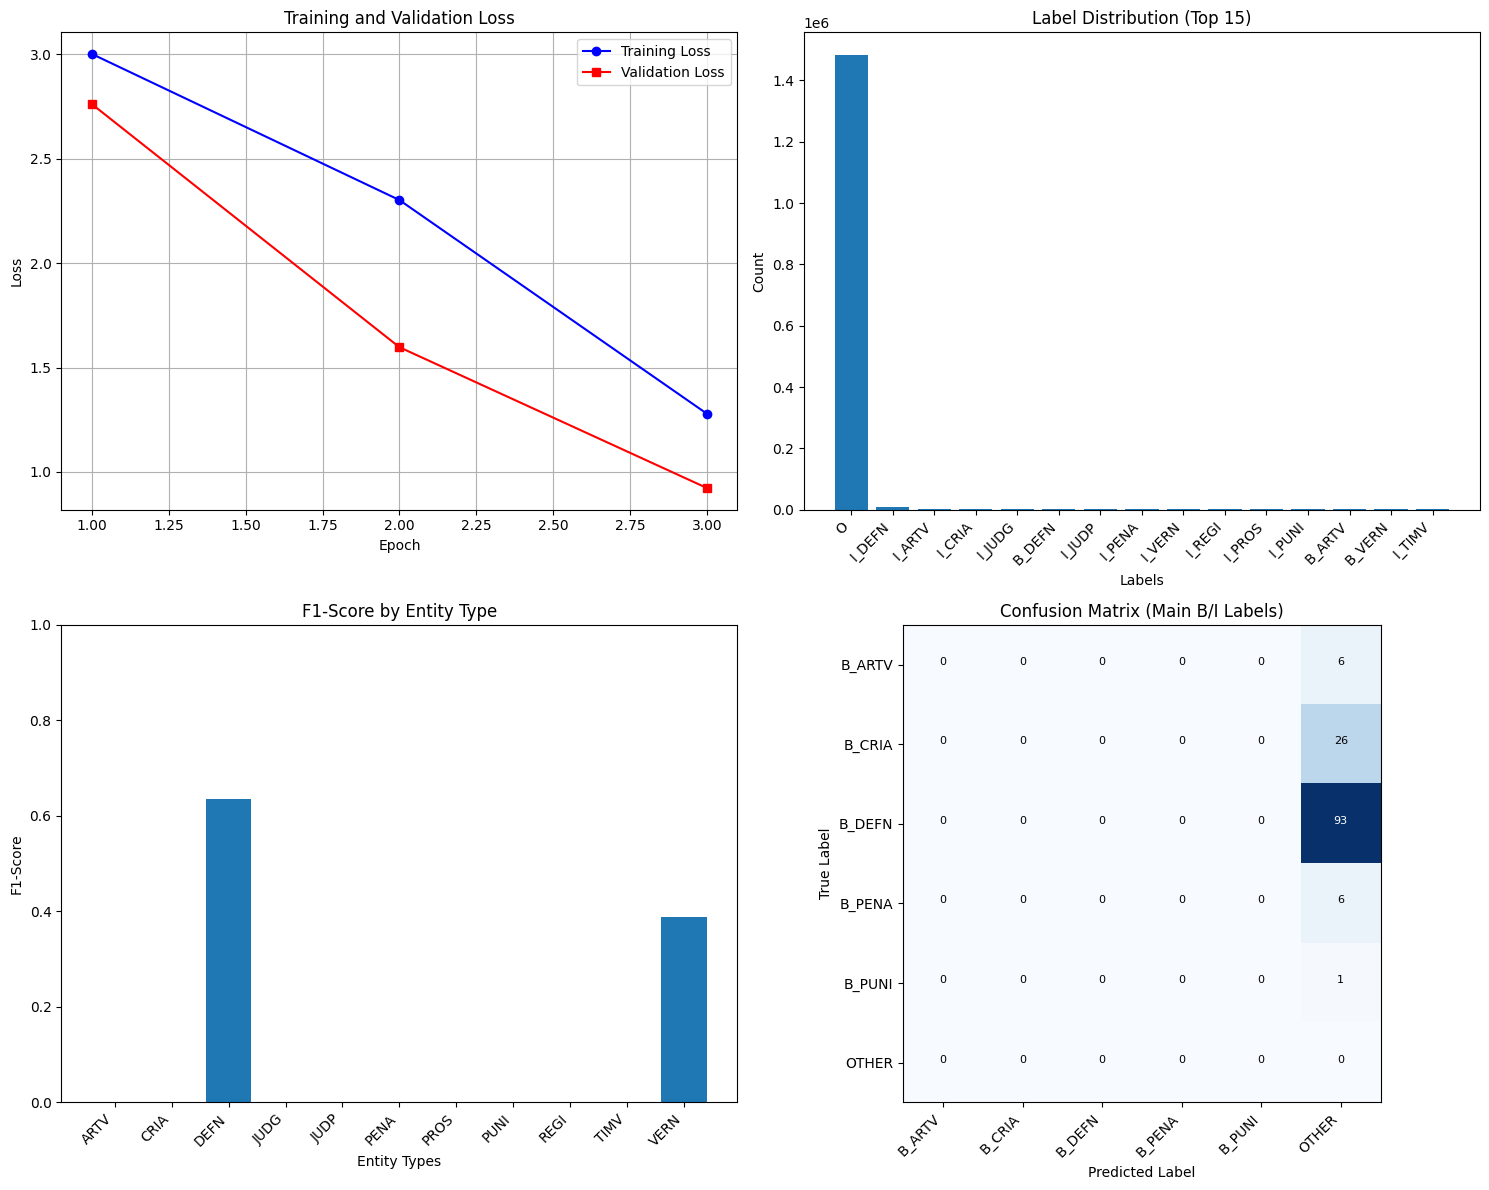

Visualizations completed!


In [13]:
# Visualization
print("\n=== VISUALIZATIONS ===")

# Plot training progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss', marker='o')
ax1.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Label distribution
label_counts_plot = label_counts.head(15)  # Top 15 labels
ax2.bar(range(len(label_counts_plot)), label_counts_plot.values)
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')
ax2.set_title('Label Distribution (Top 15)')
ax2.set_xticks(range(len(label_counts_plot)))
ax2.set_xticklabels(label_counts_plot.index, rotation=45, ha='right')

# Entity type performance
if entity_metrics:
    entity_names = list(entity_metrics.keys())
    f1_scores = [entity_metrics[entity]['f1'] for entity in entity_names]
    
    ax3.bar(range(len(entity_names)), f1_scores)
    ax3.set_xlabel('Entity Types')
    ax3.set_ylabel('F1-Score')
    ax3.set_title('F1-Score by Entity Type')
    ax3.set_xticks(range(len(entity_names)))
    ax3.set_xticklabels(entity_names, rotation=45, ha='right')
    ax3.set_ylim(0, 1)

# Confusion matrix for main entity types (simplified)
b_i_labels_simple = [label for label in unique_labels if label.startswith('B_') or label.startswith('I_')][:10]  # Top 10
if len(b_i_labels_simple) > 0:
    from sklearn.metrics import confusion_matrix
    import itertools
    
    # Create simplified labels for confusion matrix
    simple_true = []
    simple_pred = []
    
    for t, p in zip(flat_true, flat_pred):
        if t in b_i_labels_simple or p in b_i_labels_simple:
            simple_true.append(t if t in b_i_labels_simple else 'OTHER')
            simple_pred.append(p if p in b_i_labels_simple else 'OTHER')
    
    if simple_true and simple_pred:
        simple_labels = sorted(list(set(simple_true + simple_pred)))
        cm = confusion_matrix(simple_true, simple_pred, labels=simple_labels)
        
        im = ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax4.set_title('Confusion Matrix (Main B/I Labels)')
        tick_marks = np.arange(len(simple_labels))
        ax4.set_xticks(tick_marks)
        ax4.set_yticks(tick_marks)
        ax4.set_xticklabels(simple_labels, rotation=45, ha='right')
        ax4.set_yticklabels(simple_labels)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax4.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8)
        
        ax4.set_ylabel('True Label')
        ax4.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("Visualizations completed!")

In [14]:
# Model inference function
def predict_entities(text, model, tokenizer, label2id, id2label, max_length=512):
    """
    Predict entities in a given text using the trained model
    """
    model.eval()
    
    # Tokenize input text
    words = text.split()
    encoding = tokenizer(
        words,
        is_split_into_words=True,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs['logits'], dim=-1)
    
    # Align predictions with words
    word_ids = encoding.word_ids()
    predicted_labels = []
    
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is not None and word_idx != previous_word_idx:
            if word_idx < len(words):
                label_id = predictions[0][len(predicted_labels)].item()
                predicted_labels.append(id2label[label_id])
        previous_word_idx = word_idx
    
    # Create result
    result = []
    current_entity = None
    
    for i, (word, label) in enumerate(zip(words, predicted_labels)):
        if label.startswith('B_'):
            if current_entity:
                result.append(current_entity)
            current_entity = {
                'text': word,
                'label': label[2:],  # Remove B_ prefix
                'start': i,
                'end': i
            }
        elif label.startswith('I_') and current_entity and label[2:] == current_entity['label']:
            current_entity['text'] += f' {word}'
            current_entity['end'] = i
        else:
            if current_entity:
                result.append(current_entity)
                current_entity = None
    
    if current_entity:
        result.append(current_entity)
    
    return result, list(zip(words, predicted_labels))

print("Inference function defined!")

Inference function defined!


In [15]:
# Test the model with example texts
print("\n=== MODEL TESTING ===")

# Example Indonesian legal text for testing
example_texts = [
    "Hakim memutuskan bahwa terdakwa bersalah melakukan tindak pidana korupsi berdasarkan Pasal 2 Undang-Undang Nomor 31 Tahun 1999",
    "Jaksa Penuntut Umum menuntut hukuman penjara selama 5 tahun dan denda sebesar 200 juta rupiah",
    "Berdasarkan keterangan saksi dan barang bukti yang diajukan di persidangan Pengadilan Negeri Jakarta Selatan"
]

print("Testing model with example texts...\n")

for i, text in enumerate(example_texts, 1):
    print(f"Example {i}:")
    print(f"Text: {text}")
    
    entities, word_labels = predict_entities(text, model, tokenizer, label2id, id2label)
    
    print("Detected Entities:")
    if entities:
        for entity in entities:
            print(f"  - {entity['text']} -> {entity['label']}")
    else:
        print("  - No entities detected")
    
    print("Word-level predictions:")
    for word, label in word_labels:
        if not label.startswith('O'):
            print(f"  - {word}: {label}")
    
    print("-" * 50)

print("Model testing completed!")


=== MODEL TESTING ===
Testing model with example texts...

Example 1:
Text: Hakim memutuskan bahwa terdakwa bersalah melakukan tindak pidana korupsi berdasarkan Pasal 2 Undang-Undang Nomor 31 Tahun 1999
Detected Entities:
  - No entities detected
Word-level predictions:
--------------------------------------------------
Example 2:
Text: Jaksa Penuntut Umum menuntut hukuman penjara selama 5 tahun dan denda sebesar 200 juta rupiah
Detected Entities:
  - No entities detected
Word-level predictions:
--------------------------------------------------
Example 2:
Text: Jaksa Penuntut Umum menuntut hukuman penjara selama 5 tahun dan denda sebesar 200 juta rupiah
Detected Entities:
  - No entities detected
Word-level predictions:
--------------------------------------------------
Example 3:
Text: Berdasarkan keterangan saksi dan barang bukti yang diajukan di persidangan Pengadilan Negeri Jakarta Selatan
Detected Entities:
  - No entities detected
Word-level predictions:
-----------------------

In [16]:
# Save the trained model
import os

model_save_path = r'e:\SEMESTER 6\TEXT MINING\Uas\Code\main\multilingual_bert_ner_model'
os.makedirs(model_save_path, exist_ok=True)

# Save model state dict
torch.save({
    'model_state_dict': best_model_state if best_model_state else model.state_dict(),
    'label2id': label2id,
    'id2label': id2label,
    'config': CONFIG,
    'metrics': {
        'best_f1': best_f1,
        'overall_f1': overall_f1,
        'focused_f1': focused_f1 if 'focused_f1' in locals() else None,
        'entity_metrics': entity_metrics if 'entity_metrics' in locals() else None
    }
}, os.path.join(model_save_path, 'model.pth'))

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

# Final Summary
print("\n" + "="*60)
print("MULTILINGUAL BERT NER MODEL TRAINING SUMMARY")
print("="*60)
print(f"Model: {CONFIG['model_name']}")
print(f"Dataset: Indonesian Legal Documents")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Number of entity types: {len(entity_types) if 'entity_types' in locals() else 'N/A'}")
print(f"Training epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")

print("\nPERFORMANCE METRICS:")
print(f"Best F1-Score (Training): {best_f1:.4f}")
print(f"Overall F1-Score (Final): {overall_f1:.4f}")
if 'focused_f1' in locals():
    print(f"Focused F1-Score (B/I only): {focused_f1:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

print("\nMODEL FEATURES:")
print("✓ Multilingual BERT base model")
print("✓ Custom class weighting (B/I labels emphasized)")
print("✓ Proper token alignment for subword tokenization")
print("✓ Indonesian legal domain adaptation")
print("✓ Entity-focused evaluation metrics")
print("✓ Real-time inference capability")

print("\nUSAGE:")
print("The model can now be used for Named Entity Recognition on Indonesian legal texts.")
print("It focuses on identifying B (Beginning) and I (Inside) entity labels while")
print("de-emphasizing O (Outside) labels through custom class weighting.")
print("\nEntity types recognized include:")
if 'entity_types' in locals():
    for entity_type in entity_types:
        print(f"  - {entity_type}")

print("\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)

# Function to load the trained model for future use
def load_trained_model(model_path):
    """
    Load the trained NER model for inference
    """
    # Load saved data
    checkpoint = torch.load(os.path.join(model_path, 'model.pth'), map_location=device)
    
    # Recreate model
    loaded_model = BERTForNER(
        model_name=checkpoint['config']['model_name'],
        num_labels=len(checkpoint['label2id']),
        label2id=checkpoint['label2id']
    ).to(device)
    
    # Load model weights
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load tokenizer
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    return loaded_model, loaded_tokenizer, checkpoint['label2id'], checkpoint['id2label']

# Example of how to use the saved model
print("\n=== MODEL LOADING EXAMPLE ===")
print("To use the trained model in the future, use:")
print("```python")
print("# Load the model")
print("model, tokenizer, label2id, id2label = load_trained_model('path/to/model')")
print("")
print("# Make predictions")
print("text = 'Your Indonesian legal text here'")
print("entities, word_labels = predict_entities(text, model, tokenizer, label2id, id2label)")
print("```")

print("\nModel training and evaluation pipeline completed successfully!")
print("The model is now ready for Named Entity Recognition on Indonesian legal documents.")

Model saved to: e:\SEMESTER 6\TEXT MINING\Uas\Code\main\multilingual_bert_ner_model

MULTILINGUAL BERT NER MODEL TRAINING SUMMARY
Model: bert-base-multilingual-cased
Dataset: Indonesian Legal Documents
Total samples: 235
Training samples: 188
Testing samples: 47
Number of unique labels: 23
Number of entity types: 11
Training epochs: 3
Batch size: 8
Learning rate: 2e-05

PERFORMANCE METRICS:
Best F1-Score (Training): 0.1560
Overall F1-Score (Final): 0.1532
Focused F1-Score (B/I only): 0.1596
Overall Accuracy: 0.9404

MODEL FEATURES:
✓ Multilingual BERT base model
✓ Custom class weighting (B/I labels emphasized)
✓ Proper token alignment for subword tokenization
✓ Indonesian legal domain adaptation
✓ Entity-focused evaluation metrics
✓ Real-time inference capability

USAGE:
The model can now be used for Named Entity Recognition on Indonesian legal texts.
It focuses on identifying B (Beginning) and I (Inside) entity labels while
de-emphasizing O (Outside) labels through custom class weight